<a href="https://colab.research.google.com/github/alifabdullah/DataScience/blob/main/BUSI_project_VIT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###All library



In [3]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pretrained models
import timm

# Kaggle dataset utility
import kagglehub


###### Import Dataset

In [4]:
# Custom Dataset for Breast Ultrasound Images
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, img_size=224):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Resize images
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')  # Grayscale
        img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


###Train Model

In [5]:
# Function to train the model
def train(model, loader, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    criterion = nn.CrossEntropyLoss()

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Function to validate the model
def validate(model, loader, device):
    model.eval()
    total_loss, correct = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


###Download Data

In [6]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")
print("Path to dataset files:", path)

data_dir = os.path.join(path, "Dataset_BUSI_with_GT")

# Get class folders and image paths
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
filepaths, labels = [], []

for i, c in enumerate(classes):
    class_dir = os.path.join(data_dir, c)
    for f in os.listdir(class_dir):
        if f.endswith('.png') and 'mask' not in f:
            filepaths.append(os.path.join(class_dir, f))
            labels.append(i)

# Split into train and validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels
)

# Create Dataset and DataLoader
train_ds = UltrasoundDataset(train_imgs, train_labels)
val_ds = UltrasoundDataset(val_imgs, val_labels)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


### ViT

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ViT model with grayscale input
model = timm.create_model('vit_base_patch16_224', pretrained=True, in_chans=1, num_classes=len(classes))
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [ ]:
### Run Model

In [11]:
# Store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20 # Increased epochs from 10 to 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, device)

    print(f'Epoch {epoch+1}: train_acc={train_acc:.4f} val_acc={val_acc:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Save the trained model
torch.save(model.state_dict(), 'vit_breast_ultrasound.pth')

Epoch 1: train_acc=0.9006 val_acc=0.7115
Epoch 2: train_acc=0.9792 val_acc=0.7564
Epoch 3: train_acc=0.9792 val_acc=0.7500
Epoch 4: train_acc=0.9872 val_acc=0.7308
Epoch 5: train_acc=0.9760 val_acc=0.7692
Epoch 6: train_acc=0.9936 val_acc=0.7885
Epoch 7: train_acc=0.9888 val_acc=0.7436
Epoch 8: train_acc=0.9824 val_acc=0.6859
Epoch 9: train_acc=0.9744 val_acc=0.6923
Epoch 10: train_acc=0.9551 val_acc=0.7051
Epoch 11: train_acc=0.9776 val_acc=0.6859
Epoch 12: train_acc=0.9776 val_acc=0.6795
Epoch 13: train_acc=0.9551 val_acc=0.7564
Epoch 14: train_acc=0.9952 val_acc=0.7372
Epoch 15: train_acc=1.0000 val_acc=0.7500
Epoch 16: train_acc=1.0000 val_acc=0.7692
Epoch 17: train_acc=1.0000 val_acc=0.7692
Epoch 18: train_acc=1.0000 val_acc=0.7692
Epoch 19: train_acc=1.0000 val_acc=0.7692
Epoch 20: train_acc=1.0000 val_acc=0.7692


###Accuracy and Loss

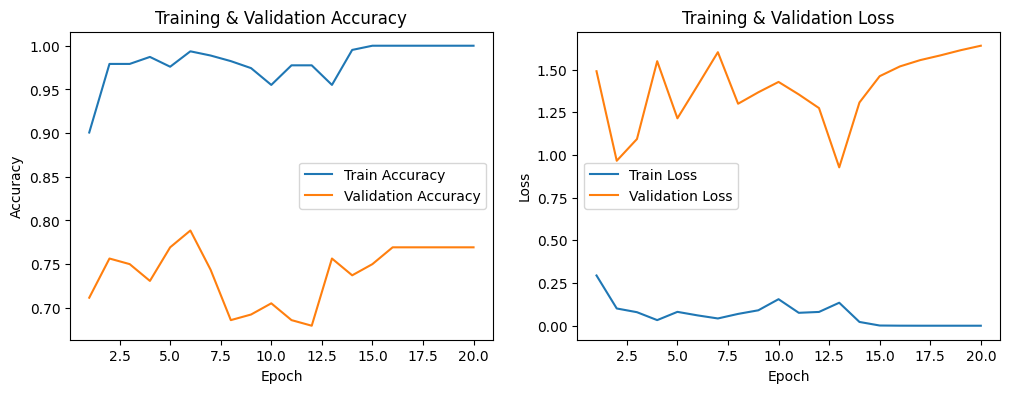

In [14]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


###Confution Metrix

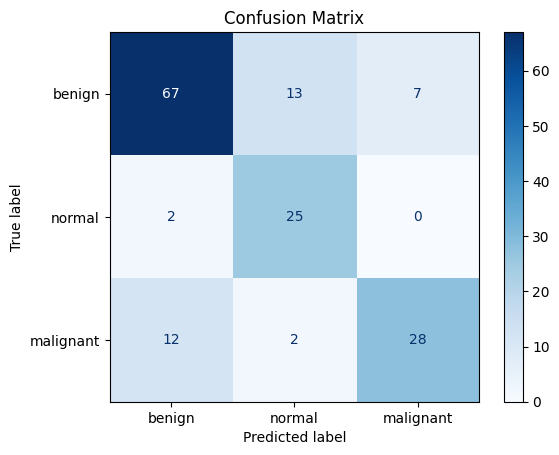

In [15]:
# Evaluate on validation set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


###Classification Report

In [16]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.77      0.80        87
      normal       0.62      0.93      0.75        27
   malignant       0.80      0.67      0.73        42

    accuracy                           0.77       156
   macro avg       0.75      0.79      0.76       156
weighted avg       0.78      0.77      0.77       156

